In [1]:
import pymaster as nmt
import numpy as np
import healpy as hp
import wget
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec

These notebooks aim to provide a comprehensive review of the functionality implemented in NaMaster. No rigorous mathematical derivations of any statements made will be provided, and users are referred to the references below for further details:
- **A19**. The original NaMaster paper (Alonso et al. 2019 https://arxiv.org/abs/1809.09603).
- **G19**. Garcia-Garcia et al. 2019 (https://arxiv.org/abs/1906.11765), which introduces the basic approximation used by NaMaster to estimate covariance matrix.
- **N20**. Nicola et al. 2020 (https://arxiv.org/abs/2010.09717), which refined these approximations and described in detail the procedure to estimate cosmic shear power spectra.
- **W24**. Wolz et al. 2024 (https://arxiv.org/abs/2407.21013), which introduced the formalism for catalog-based $C_\ell$s.
- **A24**. Alonso 2024 (https://arxiv.org/abs/2410.07077), which generalised the estimator to anisotropic weights.
- **C25**. Cornish et al. 2025 (arXiv TBD), which developed deprojection techniques for catalog-based $C_\ell$s.

# 6 Deprojection in catalog-based fields
This tutorial explains how to take advantage of deprojection techniques to obtain unbiased power spectrum measurements for catalog-based fields. To know more about how these fields work, take a look at Tutorial 4.

In the tutorial we will generate realisations of a catalog-based field, including contamination from an unknown linear combination of known contaminants. We will then show that, after applying linear deprojection, and accounting for the bias to the power spectrum induced by it, we can obtain unbiased $C_\ell$ measurements.

# Table of contents

* [6.1 Infrastructure for generating simulated fields](#Ss6.1)
* [6.2 Validation](#Ss6.2)

## 6.1 Infrastructure for generating simulated fields <a class="anchor" id="Ss6.1"></a>
Below we set things up to generate simulations. The three most important elements are:

* Realistic catalog positions. We will take these from the Quaia quasar sample of [Storey-Fisher et al. 2023](https://arxiv.org/abs/2306.17749).
* A signal model for the field. For this we will generate realisations of a field with a power spectrum $C_\ell=1/(\ell+10)$.
* A set of contaminants. We will generate 10 systematic contaminant templates, drawing them from a power spectrum $C_\ell^{\rm syst}\propto 1/(\ell+10)^3$. From this, we will build a single contaminant, given by the direct sum of all templates. Later on we will pretend not to know this, however! We will instead deproject all contaminant templates separately.

In [2]:
# Map resolution we'll use to generate simulations
nside = 256
npix = hp.nside2npix(nside)
lmax = 3*nside-1
lmax_nside = 3*nside-1

# Download and read Quaia object positions function
fname_cat = 'quaia_G20.5.fits'
if not os.path.isfile(fname_cat):
    wget.download("https://zenodo.org/records/10403370/files/quaia_G20.5.fits?download=1")
cat = fits.open(fname_cat)[1].data
# Select only sources with redshifts z < 1.47 (first bin of Alonso et al. 2023)
cat = cat[cat['redshift_quaia'] < 1.47]
nsrc = len(cat)
print(f"The catalog has {nsrc} sources.")

# Catalog positions
pos_data = np.array([cat['ra'], cat['dec']])
ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
# Catalog weights
w_data = np.ones(nsrc)

The catalog has 644786 sources.


In [3]:
# Construct the signal and contaminant power spectra
ls = np.arange(lmax_nside+1)
pixwin = hp.pixwin(nside)
cl_true = 1/(ls+10)
cl_syst = 1/(ls+10)**3

# Variances of the signal and contaminant maps
var_true = np.sum((2*ls+1)*cl_true/(4*np.pi))
var_syst = np.sum((2*ls+1)*cl_syst/(4*np.pi))

# Amplitude of each contaminant, defined in
# terms of the ratio of their variances
alpha_syst = 0.3*np.sqrt(var_true/var_syst)


# Simulator function: generates a Gaussian realisation
# of a given C_ell, and samples it at the positions
# of the sources.
def gen_sim(cl=cl_true, spin=0):
    if spin == 0:
        mp = hp.synfast(cl, nside)
        fval = mp[ipix]        
    else:
        almE = hp.synalm(cl)
        almB = almE*0
        mp = np.array(hp.alm2map_spin([almE, almB], nside,
                                      spin, lmax_nside))
        fval = mp[:, ipix]
    return mp, fval

In [4]:
# Construct the 10 contaminant templates.
# The sum of them will be our unknown contamination.
ntemp = 10
systs = []
fsysts = []
for i in range(ntemp):
    s, f = gen_sim(cl=cl_syst*alpha_syst**2*0.1)
    systs.append(s)
    fsysts.append(f)
systs = np.array(systs)
fsysts = np.array(fsysts)
fsyst = np.sum(fsysts, axis=0)

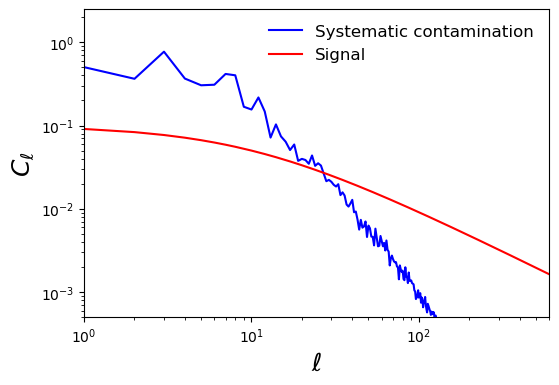

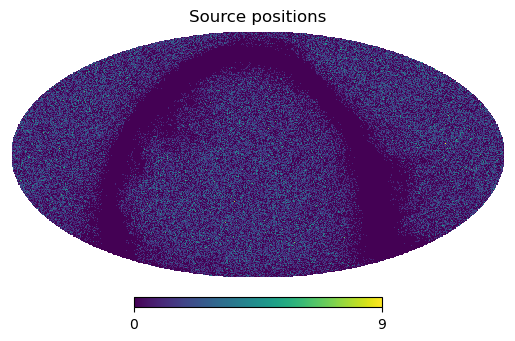

In [5]:
# Let's plot the signal and contaminant power spectra
plt.figure(figsize=(6, 4))
plt.plot(ls, hp.anafast(np.sum(systs, axis=0)), 'b-', label='Systematic contamination')
plt.plot(ls, cl_true, 'r-', label='Signal')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$', fontsize=18)
plt.loglog()
plt.ylim([5E-4, 2.5])
plt.xlim([1, 600])
plt.legend(fontsize=12, frameon=False);

# Plot the source distribution so we get an
# idea of what the data looks like
mp, fval = gen_sim()
nc_data = np.bincount(ipix, minlength=npix)
plt.figure()
hp.mollview(nc_data, title='Source positions', hold=True)

## 6.2 Validation <a class="anchor" id="Ss6.2"></a>
Now we will generate 100 signal realisations. For each of them we will:
* Add some level of uncorrelated noise.
* Add systematics.
* Compute the power spectra with and without contamination, and with and without deprojection.
* Do this also for simulations containing only the signal and noise components.

We will then use these results to validate the calculation in NaMaster of the deprojection bias components, and to show that the resulting power spectra are unbiased.

In [6]:
# First, precompute the MCM for this catalog, since this will be reused in all cases.
fld = nmt.NmtFieldCatalog(pos_data, w_data, None,
                          spin=0, lmax=lmax_nside, lonlat=True)
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=10)
w = nmt.NmtWorkspace.from_fields(fld, fld, b)
syst_temp = fsysts.reshape([ntemp, 1, -1])

In [7]:
nsims = 100
cls_ncnd = []
cls_ncd = []
cls_cnd = []
cls_cd = []
cls_sig_ncnd = []
cls_sig_ncd = []
cls_noi_ncnd = []
cls_noi_ncd = []
for i in range(nsims):
    print(i)
    mp, signal = gen_sim()
    noise = 10*np.random.randn(len(fval))*np.sqrt(var_true)

    # Not contaminated, not deprojected, S+N
    f = nmt.NmtFieldCatalog(pos_data, w_data, signal+noise,
                            lmax=lmax_nside, lonlat=True)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_ncnd.append(cl)

    # Not contaminated, not deprojected, S
    f = nmt.NmtFieldCatalog(pos_data, w_data, signal,
                            lmax=lmax_nside, lonlat=True)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_sig_ncnd.append(cl)

    # Not contaminated, not deprojected, N
    f = nmt.NmtFieldCatalog(pos_data, w_data, noise,
                            lmax=lmax_nside, lonlat=True)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_noi_ncnd.append(cl)

    # Not contaminated, deprojected, S+N
    f = nmt.NmtFieldCatalog(pos_data, w_data, signal+noise,
                            lmax=lmax_nside, lonlat=True,
                            templates=syst_temp)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_ncd.append(cl)

    # Not contaminated, not deprojected, S
    f = nmt.NmtFieldCatalog(pos_data, w_data, signal,
                            lmax=lmax_nside, lonlat=True,
                            templates=syst_temp)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_sig_ncd.append(cl)

    # Not contaminated, not deprojected, N
    f = nmt.NmtFieldCatalog(pos_data, w_data, noise,
                            lmax=lmax_nside, lonlat=True,
                            templates=syst_temp)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_noi_ncd.append(cl)

    # Contaminated, not deprojected, S+N
    f = nmt.NmtFieldCatalog(pos_data, w_data, signal+noise+fsyst,
                            lmax=lmax_nside, lonlat=True)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_cnd.append(cl)

    # Contaminated, deprojected, S+N
    f = nmt.NmtFieldCatalog(pos_data, w_data, signal+noise+fsyst,
                            lmax=lmax_nside, lonlat=True,
                            templates=syst_temp)
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f)).squeeze()
    cls_cd.append(cl)
cls_ncnd = np.array(cls_ncnd)
cls_ncd = np.array(cls_ncd)
cls_sig_ncnd = np.array(cls_sig_ncnd)
cls_sig_ncd = np.array(cls_sig_ncd)
cls_noi_ncnd = np.array(cls_noi_ncnd)
cls_noi_ncd = np.array(cls_noi_ncd)
cls_cnd = np.array(cls_cnd)
cls_cd = np.array(cls_cd)

cl_ncnd = np.mean(cls_ncnd, axis=0)
cl_ncd = np.mean(cls_ncd, axis=0)
cl_sig_ncnd = np.mean(cls_sig_ncnd, axis=0)
cl_sig_ncd = np.mean(cls_sig_ncd, axis=0)
cl_noi_ncnd = np.mean(cls_noi_ncnd, axis=0)
cl_noi_ncd = np.mean(cls_noi_ncd, axis=0)
cl_cnd = np.mean(cls_cnd, axis=0)
cl_cd = np.mean(cls_cd, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Now let's calculate theoretical prediction for the signal power spectrum. Note that we correct for the pixel window function, since our signal is sampled from a finite-resolution map.

In [8]:
cl_pred = w.decouple_cell(w.couple_cell([cl_true*pixwin**2])).squeeze()
leff = b.get_effective_ells()

And now let's calculate the noise deprojection biasm

In [9]:
f = nmt.NmtFieldCatalog(pos_data, w_data, w_data,
                        lmax=lmax_nside, lonlat=True,
                        templates=fsysts.reshape([ntemp, 1, -1]),
                        noise_variance=var_true*100)
nlb = w.decouple_cell(f.get_noise_deprojection_bias()).squeeze()

Finally, calculate the correction for the signal due to deprojection. In Cornish et al. 2025 two different approaches are proposed. One is the analytical calculation of the additive deprojection bias assuming we know the signal power spectrum. The other one is a transfer function approach via simulations. Let's try both of them.

In [10]:
# Calculate the transfer function from the signal sims
tf = cl_sig_ncd/cl_sig_ncnd

# Now calculate the deprojection bias from
# the input power spectrum.
mask = np.bincount(ipix, minlength=npix).astype(float)
f = nmt.NmtField(mask, [mask], spin=0,
                 templates=systs.reshape([ntemp, 1, -1]))
wmap = nmt.NmtWorkspace.from_fields(f, f, b)
pcl_dp = nmt.deprojection_bias(f, f, np.array([cl_true]))
slb = wmap.decouple_cell(pcl_dp).squeeze()

### 6.2.1 Validate noise deprojection bias
We start by validating our calculation of the noise deprojection bias by comparing noise-only simulations with and without deprojection.

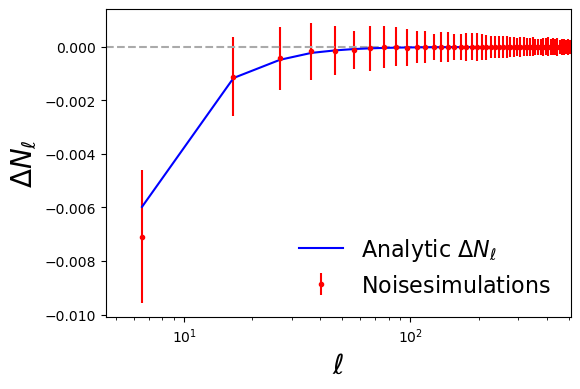

In [11]:
f = plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.errorbar(leff, np.mean(cls_noi_ncd-cls_noi_ncnd, axis=0),
            yerr=np.std(cls_noi_ncd, axis=0)/np.sqrt(nsims),
            fmt='r.', label=r'${\rm Noise simulations}$')
ax.set_xscale('log')
ax.axhline(0, c='#AAAAAA', ls='--')
ax.plot(leff, nlb, 'b-', label=r'${\rm Analytic}\,\,\Delta N_\ell$')
ax.set_xlabel(r'$\ell$', fontsize=20)
ax.set_ylabel(r'$\Delta N_\ell$', fontsize=20)
ax.set_xlim([4.5, 2*nside])
ax.legend(fontsize=16, frameon=False)

And finally, the plot below validates the two different ways to unbias your power spectra, via transfer functions or analytic deprojection bias (red vs. yellow), both giving almost identical results.

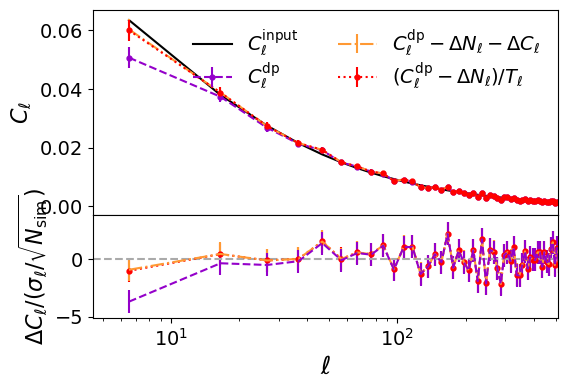

In [12]:
colred = 'r'
colyel = '#ff9933'
colpur = '#9400CA'

f = plt.figure(figsize=(6, 4))
gs = GridSpec(2, 1, height_ratios=[2,1], hspace=0)
ax_main = f.add_subplot(gs[0])
ax_resid = f.add_subplot(gs[1])
ax_main.set_xscale('log')
ax_resid.set_xscale('log')

ax = ax_main

cl_mean = np.mean(cls_cd, axis=0)
cl_std = np.std(cls_cd, axis=0)/np.sqrt(nsims)
ax.plot(leff, cl_pred, 'k-', label=r'$C_\ell^{\rm input}$')
ax.errorbar(leff, cl_mean, yerr=cl_std,
            fmt='.--', ms=7, c=colpur, label=r'$C_\ell^{\rm dp}$')
ax.errorbar(leff, cl_mean-nlb-slb,
            yerr=cl_std,
            fmt='-.', ms=7, c=colyel, label=r'$C_\ell^{\rm dp}-\Delta N_\ell-\Delta C_\ell$')
ax.errorbar(leff, (cl_mean-nlb)/tf,
            yerr=cl_std/tf,
            fmt='r.:', ms=7, label=r'$(C_\ell^{\rm dp}-\Delta N_\ell)/T_\ell$')
ax.set_xscale('log')
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim([4.5, 2*nside])
ax.legend(fontsize=14, frameon=False, labelspacing=0.1, ncol=2)

ax = ax_resid
ax.errorbar(leff, ((cl_mean-nlb)/tf-cl_pred)/cl_std,
            yerr = np.ones_like(leff),
            fmt='r.:', ms=7)
ax.errorbar(leff, (cl_mean-nlb-slb-cl_pred)/cl_std,
            yerr = np.ones_like(leff),
            fmt='-.', c=colyel, ms=7)
ax.errorbar(leff, (cl_mean-cl_pred)/cl_std,
            yerr = np.ones_like(leff),
            fmt='--', c=colpur, ms=7)
ax.set_xlim([4.5, 2*nside])
ax.axhline(0, c='#AAAAAA', ls='--')
ax.tick_params(axis='both', labelsize=14)
#ax.set_ylim([-3, 3])

ax_main.set_ylabel(r'$C_\ell$', fontsize=16)
ax_resid.set_ylabel(r'$\Delta C_\ell / (\sigma_\ell / \sqrt{N_{\rm sim}})$', fontsize=16)
ax_resid.set_xlabel(r'$\ell$', fontsize=18)
ax_main.set_xticklabels([])